## 3D analysis tutorial - 1ES1218 and 1ES1215

Tutorial for the ACME-sponsored 1st MAGIC Open Data-Analysis School: the aim for this tutorial is to simulatanously estimation of the spectrum of multiple sources in the F.o.V. It uses MAGIC telescope observations on the two blazars: 1ES1218+304 and 1ES1215+303. 

If you have question regarding the tutorial or 3d analysis, feel free to contact the organizers.

## Import packages

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import os
from regions import Regions, CircleSkyRegion
from scipy.stats import norm

## Import of gammapy modules

In [2]:
from gammapy.data import DataStore, Observations
from gammapy.datasets import Datasets
from gammapy.datasets import MapDataset

from gammapy.estimators import ExcessMapEstimator
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators import TSMapEstimator

from gammapy.makers import DatasetsMaker
from gammapy.makers import FoVBackgroundMaker
from gammapy.makers import MapDatasetMaker
from gammapy.makers import RingBackgroundMaker
from gammapy.makers import SafeMaskMaker

from gammapy.maps import MapAxis
from gammapy.maps import WcsGeom

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    LogParabolaSpectralModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    Models,
    PiecewiseNormSpectralModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel
)

Reference spectral modesl we will use in our analysis later one. One from MAGIC and one from the LST performance paper. Please find the papers at the following links: <br>
https://doi.org/10.1016/j.jheap.2015.01.002 <br>

In [3]:
magic_crab_model = LogParabolaSpectralModel(
    alpha=2.47,
    amplitude="3.23e-11 cm-2 s-1 TeV-1",
    reference=1 * u.TeV,
    beta=0.24,
)

magic_crab = SkyModel(
    spectral_model=magic_crab_model,
    name="Crab MAGIC",
)

In [46]:
def plot_spectrum(model, ax, label, color, energy_bounds= [0.08, 30] * u.TeV):
    spec = model.spectral_model
    spec.plot(
        ax=ax, energy_bounds=energy_bounds, energy_power=2, label=label, color=color
    )
    spec.plot_error(ax=ax, energy_bounds=energy_bounds, energy_power=2, color=color)

## Load observations

This defines the path, where we store the DL3 data including the background models. In addition to the data, the directory also needs to have the index files.

In [5]:
# data store
data_dir = os.path.realpath("../full_enclosure_w_bkg")

data_store = DataStore.from_dir(data_dir)
obs_ids = list(data_store.obs_table["OBS_ID"])

Since we want to perform a 3d analysis, we like to load all of the available instrument response functions (so-called, full-enclosure IRFs) and the background. 

In [6]:
observations = data_store.get_observations(
    obs_ids, 
    required_irf =["aeff", "edisp", "psf", "bkg"],
)

Now we can have a look at one of the input files and check its content (counts, irfs, and background). By changing the index number we can select a different file.

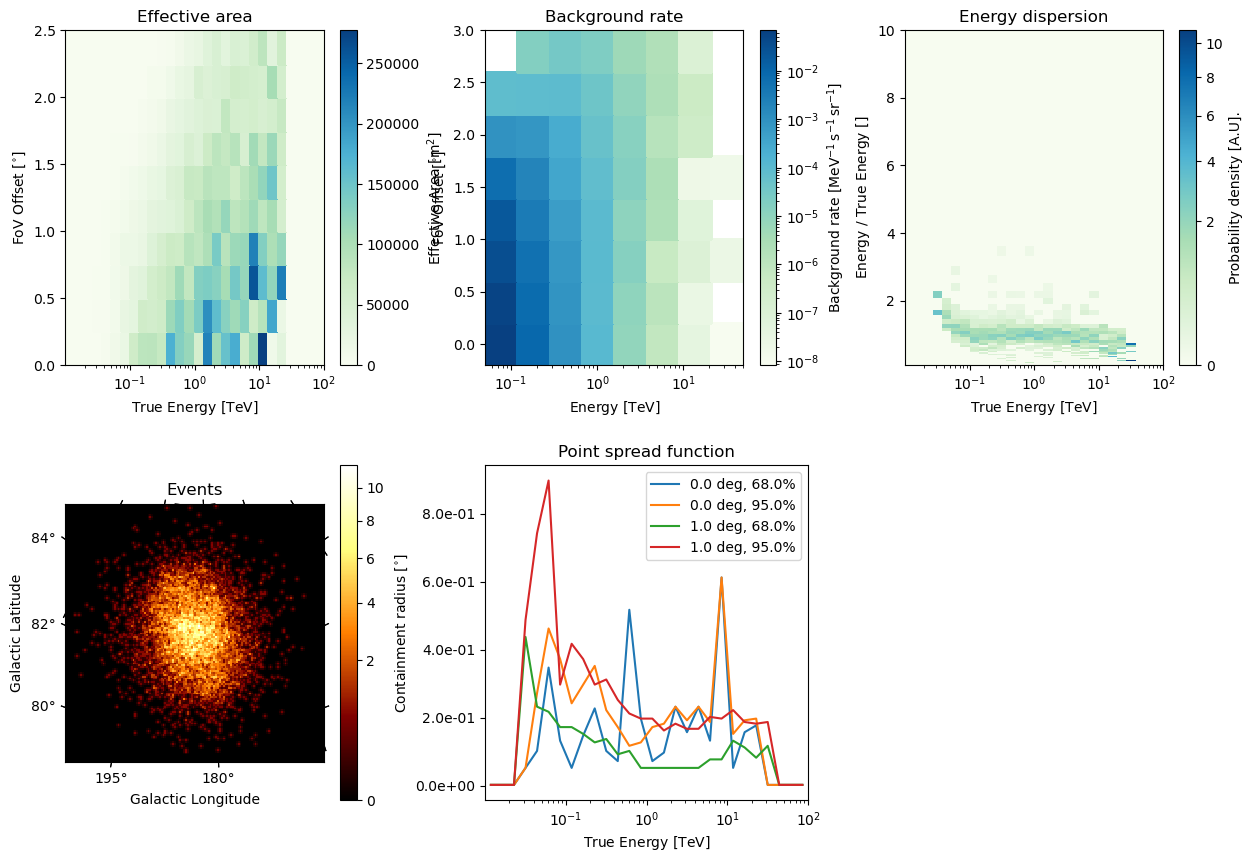

In [7]:
obs_index = 1
observations[obs_index].peek()

## Analysis settings

#### Target source

Here we define the the source of interest. In this case the sources are known, so we can retrieve their coordinates from databases by their names. If the source is not yet detected, one can also define source coordinates manuelly.

In [8]:
_1ES1215_coordinates = SkyCoord.from_name("1ES1215+303", frame="icrs")
_1ES1218_coordinates = SkyCoord.from_name("1ES1218+304", frame="icrs")

#### Energy axis

The following defines the energy binning we are going to use in our analysis. If the irfs and background are binned differently, gammapy will use interpolations. Here we limit ourself to energies, where our irfs and background are well sampled.

In [9]:
energy_axis = MapAxis.from_energy_edges(
    np.logspace(np.log10(0.08), np.log10(20), 9)*u.TeV,
    name="energy",
)

print(energy_axis.edges)

[ 0.08        0.15952637  0.31810829  0.63433327  1.26491106  2.52233341
  5.02973372 10.02968964 20.        ] TeV


#### Image scale

Here we can define the spatial scales, the size of the image and its binning.

In [10]:
width = (2., 2.) # (3.0, 3.0), (2.8, 1.2)
binsz = 0.02
npix = (int(width[0]/binsz), int(width[1]/binsz))

#### Create WCS

The binning defined previously is now combined into a single world coordinate system (WCS) object, which is used throughout our analysis.

In [11]:
geom = WcsGeom.create(
    skydir = _1ES1215_coordinates, 
    npix = npix,
    binsz = binsz,
    frame = "icrs",
    proj = "AIR",
    axes = [energy_axis],
)

#### Create datasets

For the following analysis we need to convert the irfs and data from camera coordinates into skycoordinates. This is done by so-called makers. In addition we define a safe mask, which exludes all the regions beyond 2 deg from the centre of our telescopes as the irfs in that region are insufficiently sampled and thus not well determined. 

Finally, we loop over all the observations and create the maps objects for each. The observations however as still separate objects, so single datasets.

In [12]:
base_map_dataset = MapDataset.create(geom=geom)
unstacked_datasets = Datasets()
maker = MapDatasetMaker(selection=["counts", "background", 'psf', 'edisp', 'exposure'])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.0*u.deg)

for obs in observations:
    dataset = maker.run(base_map_dataset.copy(), obs)
    dataset = maker_safe_mask.run(dataset, obs)
    unstacked_datasets.append(dataset)

#### FoV background

##### Define exclusion region

The background should already provide a reasonable approximation, but we can improve it by further adjust the background model to the data. 

For this we want to exclude emission from sources from the normalisation of the background as it may bias the estimate. In both cases we choose a region of 0.2 deg, matching roughly the containment radius of a point source. This initial adjustment has not influence later when fitting the background again with the source to extract the spectrum, but is meant to result in better skymaps for the initial check for a source detection.

In [13]:
excl_radius = 0.3 * u.deg

_1ES1215_circle = CircleSkyRegion(center=_1ES1215_coordinates, radius=excl_radius)
_1ES1218_circle = CircleSkyRegion(center=_1ES1218_coordinates, radius=excl_radius)
exclusion_regions = [_1ES1215_circle, _1ES1218_circle]

geom_image = geom.to_image()
exclusion_mask = ~geom_image.region_mask(exclusion_regions)

#### Background fit

Now we can improve the background estimate by adjusting the background to the data. This can be achieved by two different background makers, the so-called ring background and FoV background.

The latter fits the background model to the data excluding the masked regions. The ring background loops over each pixel of the count map and extimates the number of events in a ring around. It normalises the number in the ring to the central pixel using the background model.

For details e.g. you can checkout these references: <br>
https://link.springer.com/referenceworkentry/10.1007/978-981-19-6960-7_177 <br>
https://www.mdpi.com/2218-1997/7/11/421

In [14]:
#maker_FoV_background = RingBackgroundMaker(r_in=0.5*u.deg, width=0.2*u.deg, exclusion_mask=exclusion_mask)
maker_FoV_background = FoVBackgroundMaker(method='fit', exclusion_mask=exclusion_mask)
datasets_with_FoV_background = Datasets()

Now we loop over the datasets and adjust the background for each of them. For each we check the factor by which the background needs to be adjusted. If the factor is rather large/small, it suggests that the background model is not a good description of the data (either just the rate is very different or - more concerning - the shape does not match the data well). In this case we better exclude those runs. It should in general not apply to more than 10% of the runs or one should revise the method used for the background model creation (not part of this tutorial).

In [15]:
datasets_with_FoV_background = []
unstacked_datasets_local = unstacked_datasets.copy()
for dataset in unstacked_datasets_local:
    # dataset.counts.data[~dataset.mask_safe] = 0
    dataset = maker_FoV_background.run(dataset)
    fit_result = dataset.models.to_parameters_table()
    norm_fit = fit_result[fit_result['name']=='norm']['value'][0]
    if norm_fit > 1.5 or norm_fit < 0.5:
        print(f"Fit for this dataset {dataset.name} exceeds recommended limits. The norm of the fit is {norm_fit}.")
        continue
    datasets_with_FoV_background.append(dataset)

Fit for this dataset tX-V24mD exceeds recommended limits. The norm of the fit is 0.41887441515405877.


#### Stack datasets

There are two different analysis approaches: a stacked and a joint analysis. For the stacked we combine the observations into a single dataset. For the joint we keep the datasets sepearately and fit the models to the separate datasets via a joint likelihood fit. The stacked method is faster, whereas the joint fit should be more precise as it better considers subtle differences between the runs.

In [16]:
stacked_dataset = Datasets(datasets_with_FoV_background.copy()).stack_reduce()

Now we can plot the counts, background, and excess (counts -  background). It gives you a first impression how well the maps are populated and whether a potential source is visible in the maps.

The maps plotted by gammapy are interactive, so you can select the scaling for the colorscale and the energy bin.

In [17]:
stacked_dataset.counts.smooth(0.05 * u.deg).plot_interactive(add_cbar=True)

stacked_dataset.background.smooth(0.05 * u.deg).plot_interactive(add_cbar=True)

stacked_dataset.excess.smooth(0.05 * u.deg).plot_interactive(stretch="sqrt", add_cbar=True)
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

We can see that the center of the observation was more towards 1ES1218, thus the count and background looks shifted wrt. the center of skymap shown here. The excess map already shows an enhanced emission from 1ES1218 and 1ES1215 compared to the background noise in the map.

##### Detection maps

Now we can quantify the excess in the map using significance estimators. Gammapy provides two different approaches an ExcessMapEstimator, which estimates the source significance based on the counts similar to the 1D case or a TSMapEstimator, which fits a defined source model in each pixel of the map and determines the significance for a hypothetical source from the likelihood (this is the same approach the Fermi-LAT analysis uses).

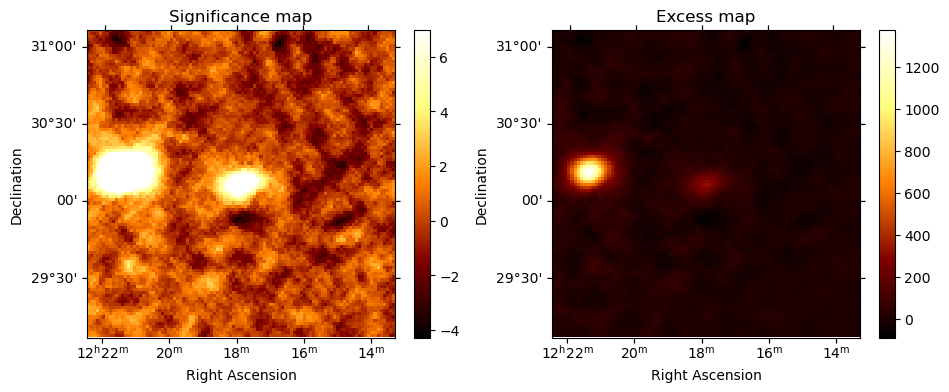

In [18]:
# to maximise the significance for a point source,
# the correlation radius should be of the size of the PSF.
# for extended sources try sqrt(psf**2+extension**2), which
# assumes a Gaussian
correlation_radius = 0.07 * u.deg
estimator = ExcessMapEstimator(correlation_radius, selection_optional=[], correlate_off=True)
lima_maps = estimator.run(stacked_dataset)

significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

# We can plot the excess and significance maps
fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 4), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)
ax1.set_title("Significance map")
significance_map.plot(ax=ax1, vmax=7, add_cbar=True)
ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)
plt.show()

The source is clearly visible, but to check whether the results are robust, it is worth to check the significance distribution of pixels. The background-only pixel should form a Gaussian with mean 0 and sigma 1 - at least approximately. If there are multiple sources in the FoV or your source extens over a significant fraction of the map, this assumption may not hold.

Fit results: mu = -0.05, std = 1.02


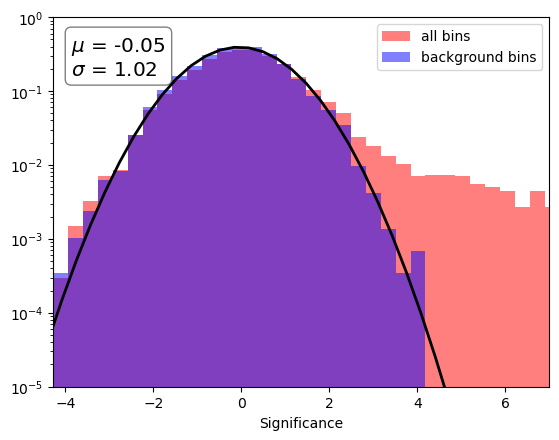

In [19]:
significance_all = lima_maps["sqrt_ts"].data[np.isfinite(lima_maps["sqrt_ts"].data)]
significance_off = lima_maps["sqrt_ts"].data[np.logical_and(np.isfinite(lima_maps["sqrt_ts"].data), exclusion_mask.data)]
bins = np.linspace(np.min(significance_all), np.max(significance_all),
                       num=int((np.max(significance_all) - np.min(significance_all)) * 3))

fig, ax = plt.subplots()
ax.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=bins,
)

ax.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="background bins",
    bins=bins,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
ax.plot(x, p, lw=2, color="black")
ax.legend()
ax.set_xlabel("Significance")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
ax.set_xlim(xmin, 7)
text = text = r'$\mu$ = {:.2f}' \
                  f'\n' \
                  r'$\sigma$ = {:.2f}'.format(mu, std)
box_prop = dict(boxstyle='Round', facecolor='white', alpha=0.5)
text_prop = dict(fontsize='x-large', bbox=box_prop)
txt = AnchoredText(text, loc=2, transform=ax.transAxes, prop=text_prop, frameon=False)
ax.add_artist(txt)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")
plt.show()

Now we are going to use TS estimator, for which we first need to define a model for our test source. As we deal here with point sources, we choose a point source for the spatial model and for the spectrum we use a power-law for simplicity. The closer your model choice is to reality the better your results will be.

In [20]:
spatial_model = PointSpatialModel()

# We choose units consistent with the map units here...
spectral_model = PowerLawSpectralModel(amplitude="1e-22 cm-2 s-1 keV-1", index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

In [21]:
estimator = TSMapEstimator(
    model,
    kernel_width="0.07 deg",
    energy_edges=[80, 8000] * u.GeV,
)
maps = estimator.run(stacked_dataset)

Text(0.5, 1.0, 'Iteration map')

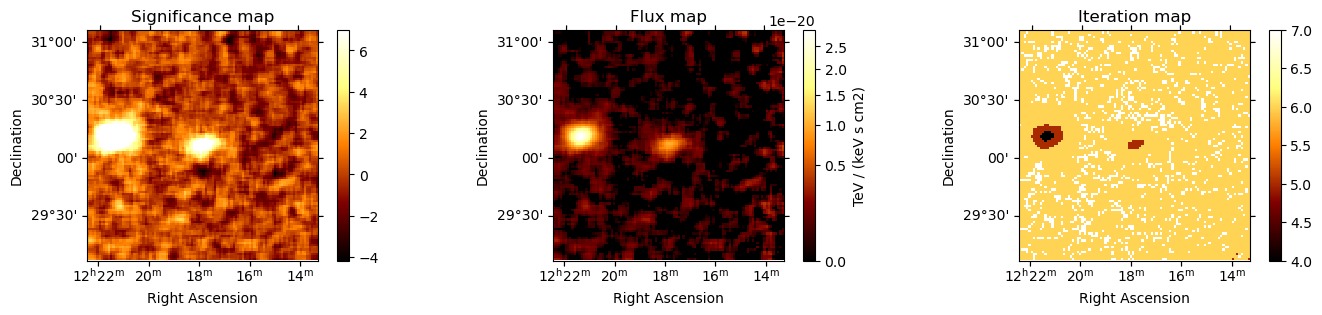

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(15, 3),
    subplot_kw={"projection": geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax=ax1, vmax=7, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")

Also this procedure clearly detected the two sources. The advantage of this method is that it also provides a map in physical meaningful units, the flux map.

#### Sky model for 1ES1215 and 1ES1215

For the 3d fit we need to define a model for the sources. Each model consists of two components, a spatial and a spectral. The spatial component in case of the the two blazars are simple as it is a point source for the resolution of the IACTs. Hence, we only need to define the position. For the spectral model we use power-law models following the findings of 1D analyses. We then combine the components into one source model for either source.

In [23]:
_1ES1215_spatial_model = PointSpatialModel(
    lon_0=_1ES1215_coordinates.ra,
    lat_0=_1ES1215_coordinates.dec,
    frame="icrs"
)
# Data from MAGIC reference paper
_1ES1215_spectral_model = PowerLawSpectralModel(
    index=3.,
    amplitude="1e-10 TeV-1 s-1 cm-2",
    reference=200. * u.GeV,
)

_1ES1215_model = SkyModel(
    spatial_model=_1ES1215_spatial_model,
    spectral_model=_1ES1215_spectral_model,
    name="1ES1215",
)

In [24]:
_1ES1218_spatial_model = PointSpatialModel(
    lon_0=_1ES1218_coordinates.ra, 
    lat_0=_1ES1218_coordinates.dec, 
    frame="icrs"
)
# Data from MAGIC reference paper
_1ES1218_spectral_model = PowerLawSpectralModel(
    index=3.,
    amplitude="1e-10 TeV-1 s-1 cm-2",
    reference=200. * u.GeV,
)

_1ES1218_model = SkyModel(
    spatial_model=_1ES1218_spatial_model,
    spectral_model=_1ES1218_spectral_model,
    name="1ES1218",
)

You can access the model parameters after the model definition this way:

In [25]:
print(_1ES1215_model.parameters['index'])

Parameter(name='index', value=3.0, factor=3.0, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, id=0x7f9f161fda50)


For the fit to perform better, we can constrain the values of each parameter to reasonable ranges. It will deliver better results and makes the fit converging faster, but requires that these ranges are known apriori.

In [26]:
_1ES1215_model.parameters['lon_0'].min = _1ES1215_coordinates.ra.value - 0.2
_1ES1215_model.parameters['lon_0'].max = _1ES1215_coordinates.ra.value + 0.2

_1ES1215_model.parameters['lat_0'].min = _1ES1215_coordinates.dec.value - 0.2
_1ES1215_model.parameters['lat_0'].max = _1ES1215_coordinates.dec.value + 0.2

_1ES1218_model.parameters['lon_0'].min = _1ES1218_coordinates.ra.value - 0.2
_1ES1218_model.parameters['lon_0'].max = _1ES1218_coordinates.ra.value + 0.1
#due to edge of the map

_1ES1218_model.parameters['lat_0'].min = _1ES1218_coordinates.dec.value - 0.2
_1ES1218_model.parameters['lat_0'].max = _1ES1218_coordinates.dec.value + 0.2

_1ES1215_model.parameters['index'].min = 0
_1ES1215_model.parameters['index'].max = _1ES1215_model.parameters['index'].value + 3

_1ES1218_model.parameters['index'].min = 0
_1ES1218_model.parameters['index'].max = _1ES1218_model.parameters['index'].value + 3

#### Energy mask

We now can define the energy range in true energy in which we like to fit the model. This does not agree with the energy range in which we extract the data and irfs. As a rule of thumb the true energy range can be a bit wider than the range in reconstructed energy. Here in addition we define the source region, in which case we only fit the source.

Alternatively, we ca only define the energy mask and then fit the source and background together across the FoV.

In [27]:
#stacked_dataset.mask_fit = stacked_dataset.counts.geom.energy_mask(
#    energy_min=0.3 * u.TeV, energy_max= 30 * u.TeV
#)

energy_mask= stacked_dataset.counts.geom.energy_mask(
    energy_min=0.08 * u.TeV, energy_max= 20 * u.TeV
)

#mask_map = dataset.counts.geom.region_mask(circle_crab)

fit_mask = energy_mask
stacked_dataset.mask_fit = fit_mask

#### Background model

In case we fit also the background we need to define a model for it as well. If we do not fit the background, the background model is just subtrackted and the source is fit on the excess map. 

The spatial model is given by the background model. For the spectrum, we can either assume that the background is scaled correctly across the bins and just apply a single scaling factor across all energy bins or we allow a different normalisation factor for each energy bin. The former is faster, but the latter should be more precise.

In [28]:
energy_center = stacked_dataset.geoms['geom'].axes['energy'].center

spectral_model_bkg = PiecewiseNormSpectralModel(
                                                energy=energy_center,
                                                norms=np.ones(energy_center.shape),
                                                )
bkg_model = FoVBackgroundModel(dataset_name="stacked", spectral_model=spectral_model_bkg)

#### Combine models and perform fit

If you like to not fit certain parameters and freeze them to the initially set values instead, you can do so the following way:

In [29]:
#model.freeze(model_type="spatial")
#bkg_model.unfreeze(model_type="spectral")

Now we define the final model to be fit to the data. In case we restricted the spatial fit region, one should better only use the source model. In case you use the entire FoV, the background can be fit as well. However, the fit of the background performed earlier should have already sufficiently optimized the background enough in this case. In case you have a complex region with several sources, we recommend to fit the background.

In [30]:
models_stacked = Models([_1ES1215_model, _1ES1218_model, bkg_model])

stacked_dataset.models = models_stacked

Finally we can run the fit using the minuit minimizer. We can defint he output level and settings for the minimizer. We save the outcome of the fit to a seperate object as well as the report from the minimizer.

In [49]:
fit = Fit(optimize_opts={"tol": 0.01, "strategy": 2, "print_level": 0})
result = fit.run(datasets=[stacked_dataset])

best_models = stacked_dataset.models.copy()
minuit = result.optimize_result.minuit

print(minuit)
print(result)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.571e+04                  │              Nfcn = 236              │
│ EDM = 0.000155 (Goal: 2e-05)     │            time = 5.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

Please always check whether the fit finished successfully. If a fit fails, please check whether the starting parameters of your input model are reasonable. It can also improve the stability of the fit to freeze or constrain some parameters. For better readability, we can also print the final results for the source parameters in separate table.

In [32]:
display(models_stacked.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
1ES1215,spectral,index,3.6562e+00,,2.879e-01,0.000e+00,6.000e+00,False,False,
1ES1215,spectral,amplitude,8.8832e-11,TeV-1 s-1 cm-2,1.121e-11,nan,nan,False,True,
1ES1215,spectral,reference,2.0000e+02,GeV,0.000e+00,nan,nan,True,False,
1ES1215,spatial,lon_0,1.8446e+02,deg,2.482e-03,1.843e+02,1.847e+02,False,False,
1ES1215,spatial,lat_0,3.0120e+01,deg,1.526e-02,2.992e+01,3.032e+01,False,False,
1ES1218,spectral,index,3.3008e+00,,6.957e-02,0.000e+00,6.000e+00,False,False,
1ES1218,spectral,amplitude,3.0393e-10,TeV-1 s-1 cm-2,1.137e-11,nan,nan,False,True,
1ES1218,spectral,reference,2.0000e+02,GeV,0.000e+00,nan,nan,True,False,
1ES1218,spatial,lon_0,1.8534e+02,deg,4.125e-03,1.851e+02,1.854e+02,False,False,


To check the agreement between the fit model and the data, we should check the residuals in the source region. If significant residuals remain the model does not describe the data very well. In our case we see that the difference between model and data are within 20%.

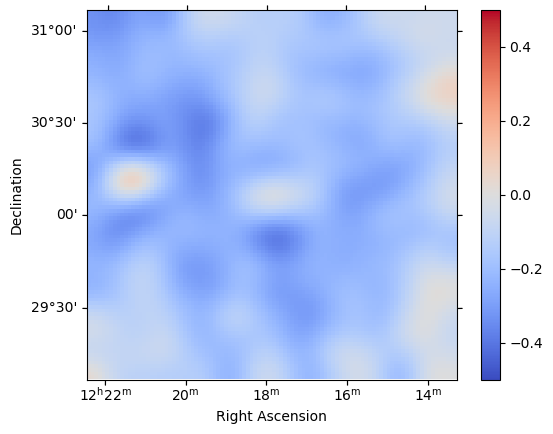

In [33]:
stacked_dataset.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)
plt.show()

For each source region one can also the data model agreement across the different energy bins to see in which energy bins one has the biggest descripancy.

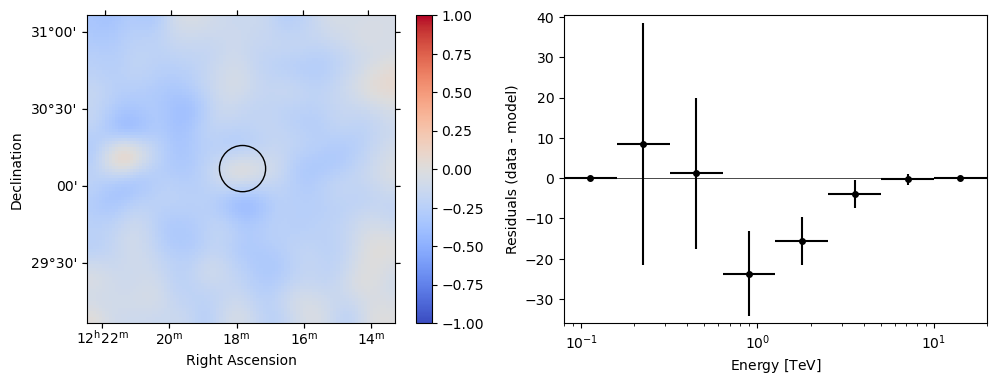

In [34]:
region = CircleSkyRegion(_1ES1215_model.position, radius=0.15 * u.deg)
stacked_dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
)
plt.show()

We can further study the spatial structure of the residual in different energy bins using the excess map estimator of gammapy again. This will show us significant residuals over our best fit model in the map.

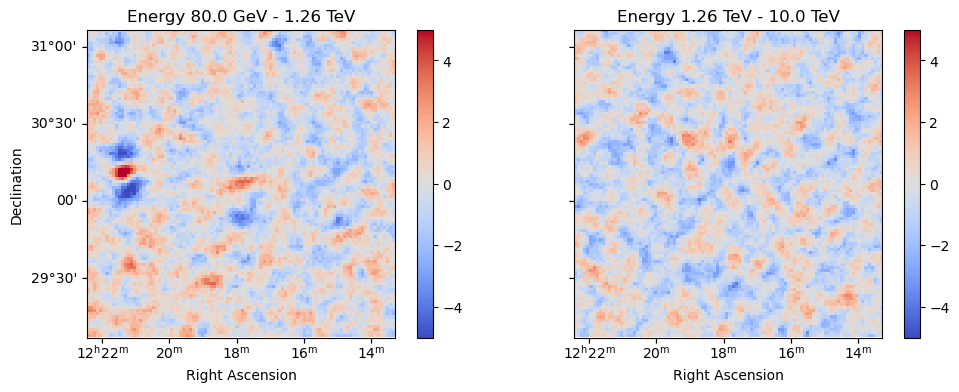

In [35]:
estimator = ExcessMapEstimator(
    correlation_radius="0.05 deg",
    selection_optional=[],
    energy_edges=[0.1, 1, 10] * u.TeV,
)

result = estimator.run(stacked_dataset)
result["sqrt_ts"].plot_grid(
    figsize=(12, 4), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
)
plt.show()

For low energies, we see an positive excess at the position of 1ES1218. This can happen for bright sources at low energies as the Monte-Carlo based PSF does not describe the tails in the real data well.  

#### Flux estimation

In addition to the spectral fit, we can estimate flux data points from the data.

In [36]:
_1ES1215_fpe = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source="1ES1215", selection_optional="all"
)
_1ES1215_flux_points = _1ES1215_fpe.run(datasets=stacked_dataset)

In [37]:
_1ES1218_fpe = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source="1ES1218", selection_optional="all"
)
_1ES1218_flux_points = _1ES1218_fpe.run(datasets=stacked_dataset)

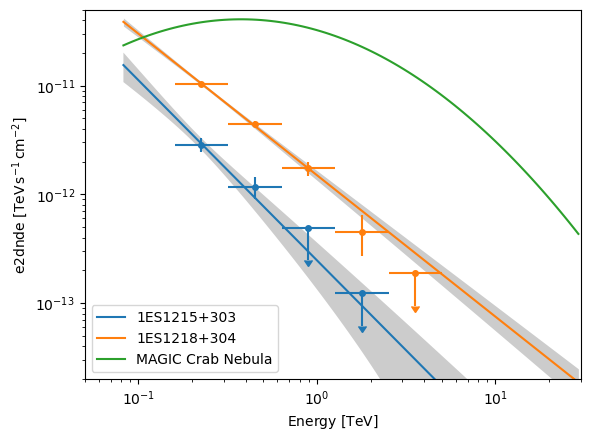

In [47]:
fig, ax = plt.subplots()

plot_spectrum(_1ES1215_model, ax=ax, label="1ES1215+303", color="tab:blue")
plot_spectrum(_1ES1218_model, ax=ax, label="1ES1218+304", color="tab:orange")
plot_spectrum(magic_crab, ax=ax, label="MAGIC Crab Nebula", color="tab:green")
_1ES1215_flux_points.plot(ax=ax, sed_type="e2dnde", color="tab:blue")
_1ES1218_flux_points.plot(ax=ax, sed_type="e2dnde", color="tab:orange")

ax.legend()
plt.xlim(0.05, 3e1)
plt.ylim(2e-14, 5e-11)
plt.show()